In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Logistic Regression

Logistic regression is another classification model. Let's upload a two class Breast Cancer dataset.

In [2]:
dataset=datasets.load_breast_cancer()
X, y = dataset.data, dataset.target
X.shape

(569, 30)

In [3]:
print(dataset['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

Here we have 569 patients with tumors. Some tumors are cancerous and some benign. We are given 30 features for each tumor. We would like to see if we can determine to which class the data point belongs based only on features. As with Neurons we want to come up with a function $f$ such that

$$ f({\bf x^{(i)}})=\begin{cases} 
      0 & x^{(i)} \text{ is malignant} \\
      1 & x^{(i)} \text{ is benign}
   \end{cases}$$

To achieve this we first consider a linear function as in linear regression: $g_{{\bf w}, b}({\bf x})={\bf w}{\bf x}+b$ and then we apply sigmoid (also known as logistic) function $s(x)=\frac{1}{1+e^{-x}}$ as our activation function. Sigmoid function will take all values of $g$ and map them between 0 and 1. We will define $f$ to be:
$$ \hat{y}=f_{{\bf w}, b}({\bf x})=s(g_{{\bf w}, b}({\bf x}))=\frac{1}{1+e^{-({\bf w}{\bf x}+b)}}$$

This is almost what we want. To actually do classification, we consider the output as the probability that ${\bf x}$ belongs to "positive" class. We can use $0.5$ as a treshhold. If $ \hat{y}<0.5$, the tumor or malignant, if $ \hat{y}>0.5$, the tumor is benign. 

This should look quite familiar. Compare below diagram to Adaline diagram

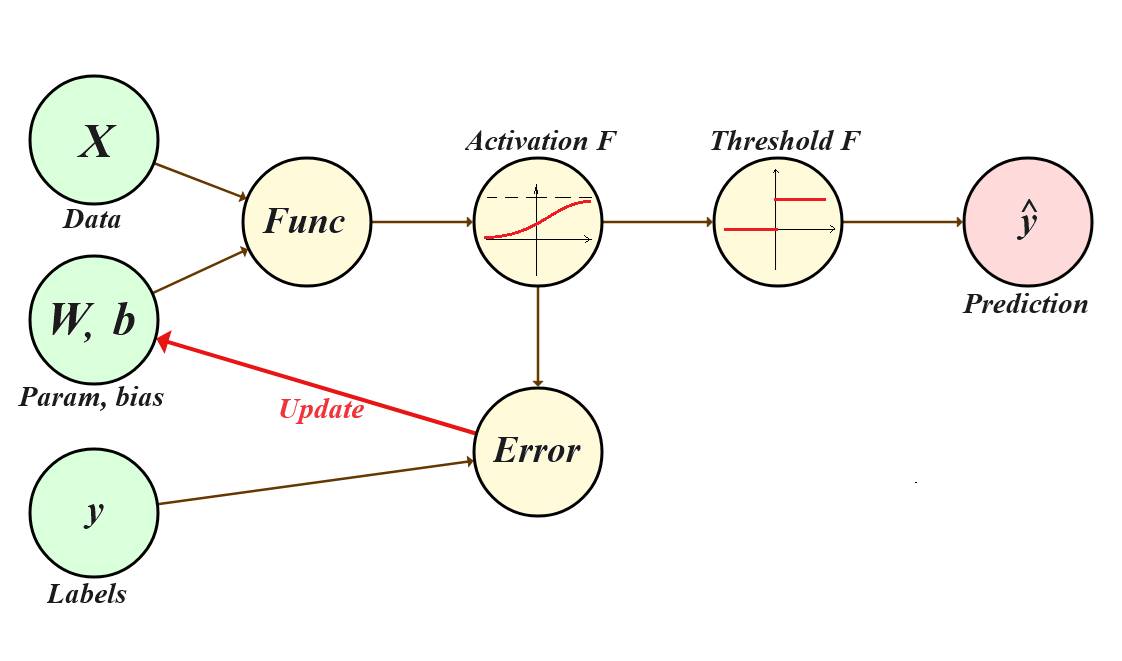

Next we need to create a loss function. We will not be using mean square estimate.  It doesn't penalize Logistic Regression model in a good way. Also, MSE might lead to trouble and give us a local minimum instead of global. What we
would like to have is low loss if we assign a low probability to the incorrect class. We’ll define a
loss function, called negative log-likelihood, that does just this. In addition, it has the
nice property that it extends nicely to the case where we would like to classify our inputs
into more than two classes.

We have to assume that our values in target set $y \in \{0,1\}$. Then the probability is
$$ L_{{\bf w}, b}=\prod_{i=1}^N [f_{{\bf w}, b}({\bf x^{(i)}})]^{y^{(i)}} [1-f_{{\bf w}, b}({\bf x^{(i)}})]^{1-y^{(i)} }$$

This is a likelihood of our model and we would like to maximize it ( it is in essence saying how likely that our model is correct). Note again that $y$ values are either 0 or 1. We multiply likelihoods of each sample to find total likelihood if all samples are independent.

Finally, to simplify this product with powers, we take a logarithm to get log-likelihood and then we negate it so that we need to minimize the problem to get negative log-likelihood function:
$$LogL_{{\bf w}, b}=-\sum_{i=1}^{N}y^{(i)} \ln(f_{{\bf w}, b}({\bf x^{(i)}}))+(1-y^{(i)})\ln(1-f_{{\bf w}, b}({\bf x^{(i)}})=-\sum_{i=1}^{N}y^{(i)} \ln(\hat{y}^{(i)})+(1-y^{(i)})\ln(1-\hat{y}^{(i)})$$

This is our loss function. Normally we also scaled it down based on sample size (so we divide by N). We can also add L2-regularization to get:

$$L=\frac{\lambda}{2N}||{\bf w}||^2-\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln(\hat{y}^{(i)})+(1-y^{(i)})\ln(1-\hat{y}^{(i)})$$

What about gradient? 

I am going to ignore L2-regularization term. Note first that sigmoid function $\sigma(x)$ has a nice derivative:

$$\frac{\partial \sigma}{\partial x}=\frac{e^{-x}}{1-e^{-x}}\frac{1}{1-e^{-x}}=\left(1-\frac{1}{1-e^{-x}}\right)\left(\frac{1}{1-e^{-x}}\right)=(1-\sigma(x))\sigma(x)$$

Derivative with respect to parameters:

$$\begin{equation}
\begin{aligned}
\frac{\partial L}{\partial {\bf w}_j} &  =  \frac{-1}{N}\sum_{i=1}^{N}\left(\frac{y^{(i)}}{\hat{y}^{(i)}}-\frac{1-y^{(i)}}{1-\hat{y}^{(i)}}\right)(1-\hat{y}^{(i)})(\hat{y}^{(i)})x^{(i)}_j \\
& =  \frac{-1}{N}\sum_{i=1}^{N} \left( y^{(i)} (1-\hat{y}^{(i)}) - (1-y^{(i)}) (\hat{y}^{(i)}) \right) x^{(i)}_j\\
& =  \frac{-1}{N}\sum_{i=1}^{N} \left(y^{(i)}- \hat{y}^{(i)}  \right) x^{(i)}_j\\
& = \frac{-1}{N} \left({\bf y}- \hat{y} \right) \cdot {\bf x}_j
\end{aligned}
\end{equation}$$

Derivative with respect to bias:
$$\frac{\partial L}{\partial  b}=\frac{-1}{N}\sum_{i=1}^{N} \left(y^{(i)}- \hat{y}^{(i)} \right)$$

Let's apply logistic regression to classify breast cancer.

## Example 1 (two features)

Let's look at some pairplots for the first 7 features:

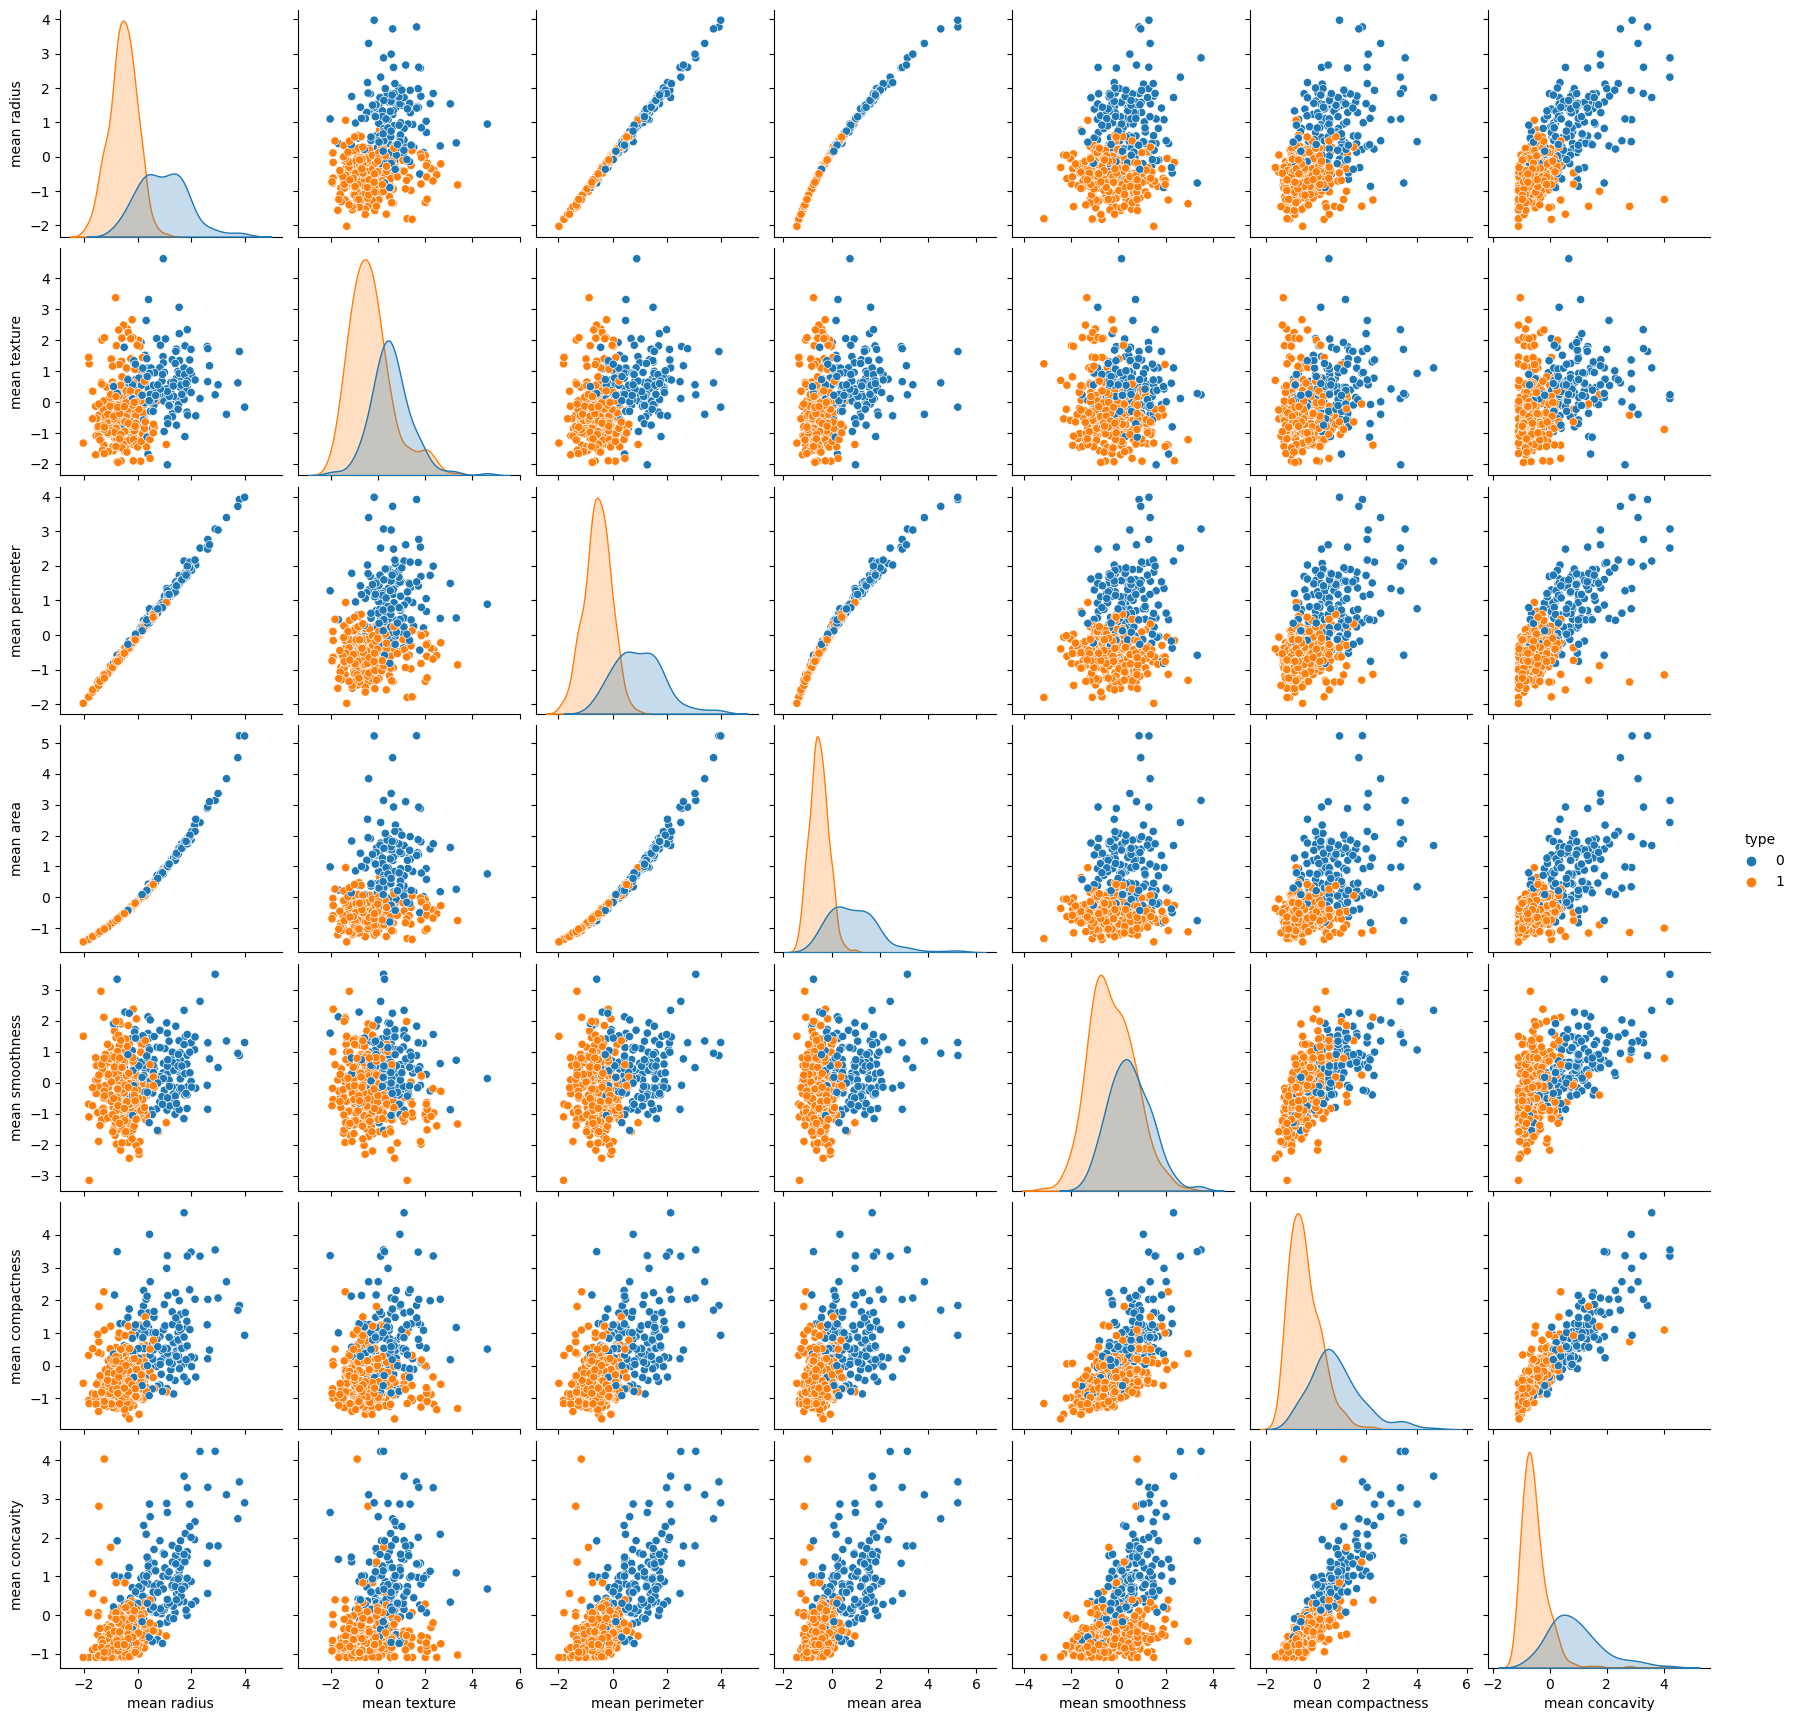

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

df = pd.DataFrame(data=X_train, columns=dataset.feature_names)
df=df.iloc[:,:7]
df['type'] = pd.DataFrame(data=y_train)

sns.pairplot(df, hue="type")
plt.show()

Fourth and fifth features have a somewhat good separation. So, lets use only them.

In [5]:
X2_train=X_train[:,[3,4]]
y2_train=y_train
X2_test=X_test[:,[3,4]]
y2_test=y_test

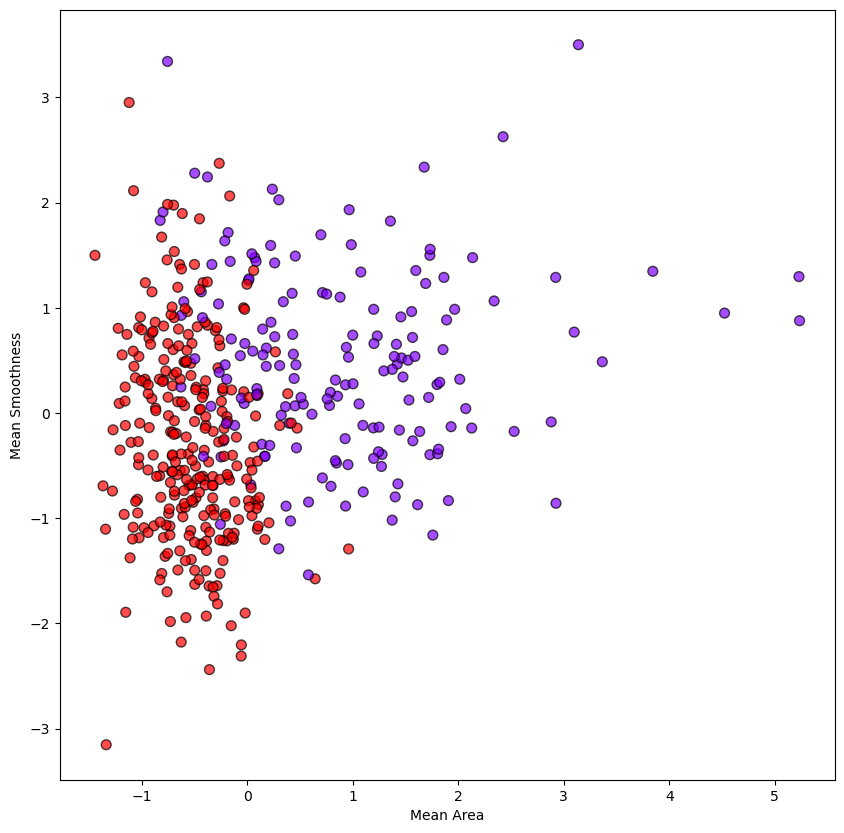

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(X2_train[:,0],X2_train[:,1] ,c=y2_train, cmap='rainbow', edgecolors='k', s=50, alpha=0.7)
plt.xlabel('Mean Area')
plt.ylabel('Mean Smoothness')
plt.show()

As you can see it is still mixed a bit, so we wont have a great separation, but let's see what we can get. In the first example I will use actual computation and later `sklearn` library commands.

In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogRegSimple():
    def __init__(self, lr=0.1, n_epoch=100):
        self.lr=lr
        self.n_epoch=n_epoch
        self.weights=None
        self.bias=None

    def forward(self, X):
        return sigmoid(np.dot(X, self.weights)+self.bias)
        
    def fit(self, X, y):
        self.weights=np.array([0,0])
        self.bias=0


        for epoch in range(self.n_epoch):
            y_pred=self.forward(X)
            loss=(np.dot(-y, np.log(y_pred))-np.dot(1-y, 1-np.log(y_pred)))/X.shape[0]

            self.weights=self.weights+self.lr*np.dot(X.T, y-y_pred)/X.shape[0]
            self.bias+=self.lr*(y-y_pred).mean()

        return self
        
    def predict(self, X):
        return self.forward(X).round()
    def param(self):
        return self.weights, self.bias

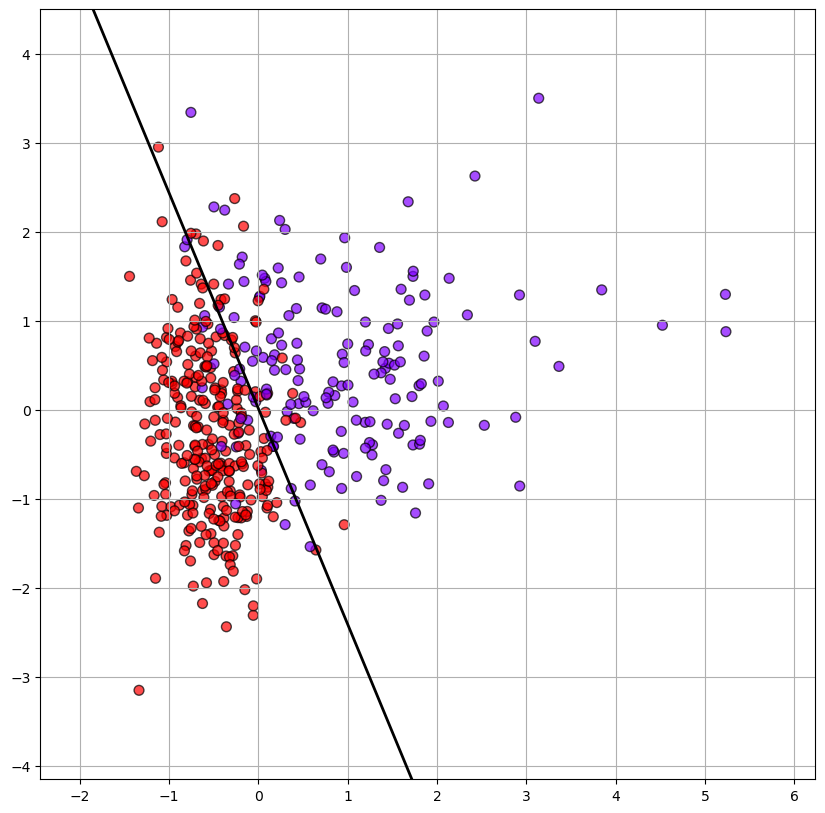

In [12]:
model=LogRegSimple(lr=0.1)
model.fit(X2_train, y2_train)


xv=np.arange(-2,5, 0.1)
w,b=model.weights, model.bias
yv=(-xv*w[0]-b+0.5)/w[1]

plt.figure(figsize=(10,10))
plt.scatter(X2_train[:,0],X2_train[:,1] ,c=y2_train, cmap='rainbow', edgecolors='k', s=50, alpha=0.7)
plt.plot(xv, yv, linewidth=2, c='k')
plt.xlim([X2_train[:,0].min()-1, X2_train[:,0].max()+1])
plt.ylim([X2_train[:,1].min()-1, X2_train[:,1].max()+1])
plt.grid()
plt.show()

Here is a nice helper function to plot our decision regions. The inputs are the array of features, array of target values and the model that has predict method.



In [9]:

# Helper function to plot a decision boundary.
def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    markers = ('s', 'x', 'o', '^', 'v')      
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


    for idx, cl in enumerate(np.unique(y)): 
        plt.scatter(X[y==cl, 0], X[y==cl, 1],  color=cmap(idx),edgecolors='k',marker=markers[idx],label=cl)



Here is what it looks like on training set:

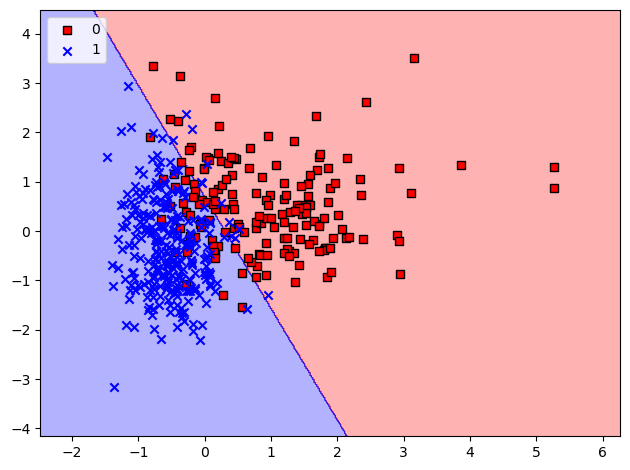

In [12]:
plot_decision_boundary(X2_train, y2_train, model)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Let's see how well we do with test data

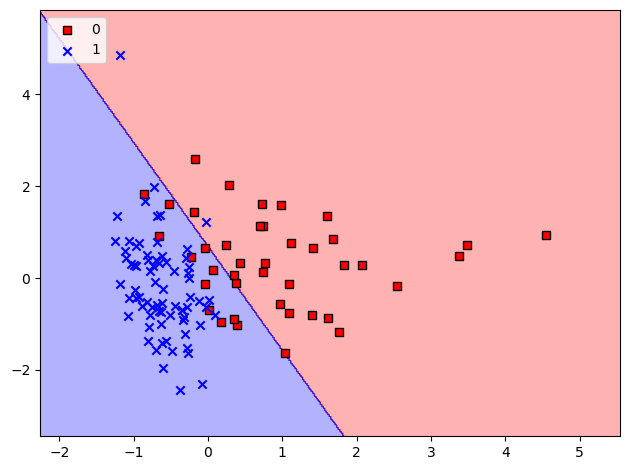

In [13]:
plot_decision_boundary(X2_test, y2_test, model)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

A nice way to see accuracy of classification test is through confusion matrix. Along the main diagonal, you can see correct guesses. Other values are inccorect guesses.

In [17]:
y_test_pred=model.predict(X2_test)
confusion_matrix(y2_test,y_test_pred)

array([[28, 10],
       [ 0, 76]], dtype=int64)

### SKlearn
We can do this quite fast and nicely using sklearn library. Note: Sklearn doesnt use gradient descent algorithm, so there is no learning rate.

In [18]:
SKLLogReg = LogisticRegression()
SKLLogReg.fit(X2_train, y2_train)
predictions =SKLLogReg.predict(X2_test)
confusion_matrix(y2_test, predictions)

array([[31,  7],
       [ 1, 75]], dtype=int64)

If you want logistic regression with SGD, then we can use `SGDClassifier` with `log_loss` loss function. That said, it is generally recommended to use above approach as it uses a better solver that works well with multiclass data.

In [19]:
SKLLogReg2 = SGDClassifier(loss='log_loss', max_iter=100, learning_rate='constant', eta0=0.001)
SKLLogReg2.fit(X2_train, y2_train)
predictions =SKLLogReg2.predict(X2_test)
confusion_matrix(y2_test, predictions)

array([[30,  8],
       [ 0, 76]], dtype=int64)

### Example 2 PyTorch + Using the whole set

In [16]:
## If you want to compare to Example 1, replace "X_train" with "X2_train". Same for other 3 arrays

X2_train=torch.tensor(X2_train, dtype=torch.float)
y2_train=torch.tensor(y2_train, dtype=torch.int)
X2_test=torch.tensor(X2_test, dtype=torch.float)
y2_test=torch.tensor(y2_test, dtype=torch.int)

n_samples, n_features = X_train.shape
y_train=y_train.view(y_train.shape[0], 1) 
y_test=y_test.view(y_test.shape[0], 1) 



In [17]:
class PTLogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(PTLogisticRegression, self).__init__()
        self.linear= nn.Linear(n_features, 1)
    def forward(self,x):
        y_pred=torch.sigmoid(self.linear(x))
        return y_pred

    

In [18]:
lr=0.1
n_epoch=100

Now the new stuff. `BCELoss` is the negative log loss (Binary Cross Entropy). If you look inside our optimizer, you can see the attribute `weight_decay`, that's the $\lambda$ for L2-regularization.

In [19]:
model=PTLogisticRegression(n_features)

lossfunc=nn.BCELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr, weight_decay=0)

In [20]:

train_loss=[]
test_loss=[]


for epoch in range(n_epoch):
    model.train()
    y_pred=model(X_train)
    loss=lossfunc(y_pred, y_train)
    loss.backward()   
    train_loss.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    


    model.eval()
    with torch.inference_mode(): 
        y_test_pred=model(X_test)
        lost_test=lossfunc(y_test_pred, y_test)
        test_loss.append(lost_test)
    
    #print(f' epoch {epoch+1}: Train Loss = {loss:.3f}Sta, Test Loss= {lost_test:.3f}')   

    

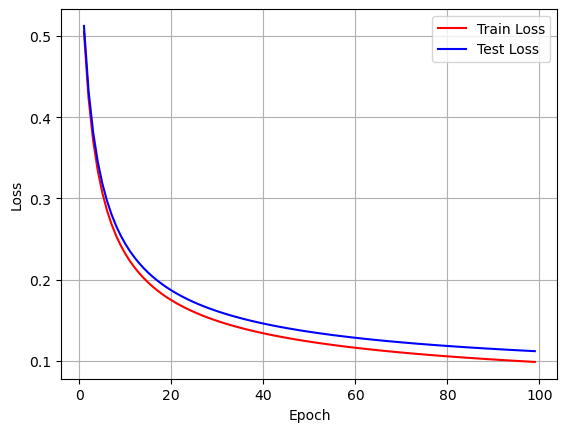

In [21]:
fig=plt.figure()
xv=np.arange(1, n_epoch,1)
plt.plot(xv,train_loss[1:], 'r', label="Train Loss")
plt.plot(xv,test_loss[:-1], 'b', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Let's see how many clasifications we got right. For that I will use confusion matrix. We will round our `y_test_pred` to so that our values are only 0 or 1.

In [22]:
y_test_pred=y_test_pred.round()
confusion_matrix(y_test,y_test_pred)

array([[42,  2],
       [ 1, 69]], dtype=int64)

We can use below code to reset parameters of our model or you can just re-create a new model

In [29]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model.apply(weight_reset)

PTLogisticRegression(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)